# Does the linear regression make sense?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import functions as f
import random

In [2]:
import scipy.stats as st

def get_pvalue(count, permut):
    # calculating p-value without first and last group, since std is 0 here. 
    z_score = (np.array(count['matches'][1:-1])-np.array(permut['mean'][1:-1]))/np.array(permut['std'][1:-1])


    #cumulative distribution function
    # --> not sure if I should take 1- ? for righttailed test? yes. or just use sf.
    p_values = st.norm.sf(z_score)


    # significance 5%
    top = st.norm.ppf(.975)
    bottom = st.norm.ppf(.025)
    
    return (p_values, z_score)

# Permutations

In [3]:
# import permutation scores
percentages = list(np.arange(0, 1.02, 0.02))

In [10]:
# import results from pca model
pca_permut160 = pd.read_pickle('pca/permutations.pkl')

pca_count160 = pd.DataFrame(pd.read_pickle('pca/count.pkl'), columns = ['matches'])
pca_permut160['percentages'], pca_count160['percentages']=percentages, percentages

pca_p_values, pca_z_scores = get_pvalue(count = pca_count160, permut = pca_permut160)

<ipython-input-2-a809863ac0a1>:5: RuntimeWarning: invalid value encountered in true_divide
  z_score = (np.array(count['matches'][1:-1])-np.array(permut['mean'][1:-1]))/np.array(permut['std'][1:-1])


In [9]:
# import results from pls model
pls_permut160 = pd.read_pickle('pls/permutations.pkl')

pls_count160 = pd.DataFrame(pd.read_pickle('pls/count.pkl'), columns = ['matches'])
pls_permut160['percentages'], pls_count160['percentages']=percentages, percentages

pls_p_values, pls_z_scores = get_pvalue(count = pls_count160, permut = pls_permut160)

pls_full using all components is way worse. --> maybe I can optimize this. 

In [29]:
# import results from linear model
linear_permut160 = pd.read_pickle('linearQuick/permutations.pkl')

linear_count160 = pd.DataFrame(pd.read_pickle('linearQuick/count.pkl'), columns = ['matches'])
linear_permut160['percentages'], linear_count160['percentages']=percentages, percentages

linear_p_values, linear_z_scores = get_pvalue(count = linear_count160, permut = linear_permut160)

In [28]:
# import results from linearM model
linearM_permut160 = pd.read_pickle('linear/permutations.pkl')

linearM_count160 = pd.DataFrame(pd.read_pickle('linear/count.pkl'), columns = ['matches'])
linearM_permut160['percentages'], linearM_count160['percentages']=percentages, percentages

linearM_p_values, linearM_z_scores = get_pvalue(count = linearM_count160, permut = linearM_permut160)

In [22]:
# import results from ridge model
ridge151_permut160 = pd.read_pickle('ridge151/permutations.pkl')

ridge151_count160 = pd.DataFrame(pd.read_pickle('ridge151/count.pkl'), columns = ['matches'])
ridge151_permut160['percentages'], ridge151_count160['percentages']=percentages, percentages

ridge151_p_values, ridge151_z_scores = get_pvalue(count = ridge151_count160, permut = ridge151_permut160)

In [23]:
# import results from ridge model
ridge_permut160 = pd.read_pickle('ridge/permutations.pkl')

ridge_count160 = pd.DataFrame(pd.read_pickle('ridge/count.pkl'), columns = ['matches'])
ridge_permut160['percentages'], ridge_count160['percentages']=percentages, percentages

ridge_p_values, ridge_z_scores = get_pvalue(count = ridge_count160, permut = ridge_permut160)

In [20]:
# import results from rf model
rf_permut160 = pd.read_pickle('rf_md30/permutations.pkl')

rf_count160 = pd.DataFrame(pd.read_pickle('rf_md30/count.pkl'), columns = ['matches'])
rf_permut160['percentages'], rf_count160['percentages']=percentages, percentages

rf_p_values, rf_z_scores = get_pvalue(count = rf_count160, permut = rf_permut160)

In [15]:
rf_permut160

,mean,std,percentage,percentages
0,0.0,0.0,0.00,0.00
1,92.0,0.0,0.02,0.02
2,92.0,0.0,0.04,0.04
3,92.0,0.0,0.06,0.06
4,92.0,0.0,0.08,0.08
5,92.0,0.0,0.10,0.10
6,92.0,0.0,0.12,0.12
7,92.0,0.0,0.14,0.14
8,92.0,0.0,0.16,0.16
9,92.0,0.0,0.18,0.18


Text(0, 0.5, 'p-value')

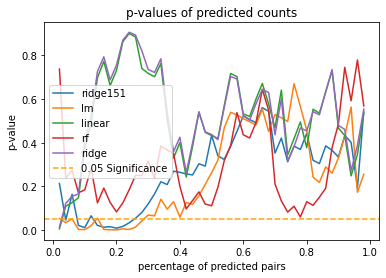

In [31]:
ax = sns.lineplot(x = percentages[1:-1], y = ridge151_p_values, label = 'ridge151')
sns.lineplot(x = percentages[1:-1], y = linearM_p_values, label = 'lm')
sns.lineplot(x = percentages[1:-1], y = linear_p_values, label = 'linear')
sns.lineplot(x = percentages[1:-1], y = rf_p_values, label = 'rf')
#sns.lineplot(x = percentages[1:-1], y = imp_pca_p_values, label = 'imp_pca')
sns.lineplot(x = percentages[1:-1], y = ridge_p_values, label = 'ridge')
ax.axhline(0.05, ls = '--', c='orange', label = '0.05 Significance')
ax.legend()
ax.set_title('p-values of predicted counts')
ax.set_xlabel('percentage of predicted pairs')
ax.set_ylabel('p-value')

In [10]:
# random forest: the first one is better somehow.. maybe becuse also the features are being selected..

Text(0.5, 1.0, 'Number of matches with increasing coefficient values')

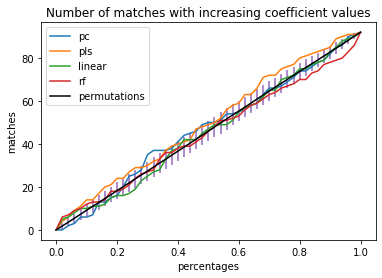

In [38]:
ax = sns.lineplot(data = pca_count160, x='percentages', y = 'matches',label='pc')
ax = sns.lineplot(data = pls_count160, x='percentages', y = 'matches',label='pls')
ax = sns.lineplot(data = linear_count160, x='percentages', y = 'matches',label='linear')
ax = sns.lineplot(data = rf_count160, x='percentages', y = 'matches',label='rf')
ax = sns.lineplot(data = pca_permut160, x ='percentages', y = 'mean', label='permutations', color='black')
ax.errorbar(pca_permut160['percentages'], pca_permut160['mean'], yerr=pca_permut160['std'], fmt=' ', zorder=-1)
ax.legend()
ax.set_title('Number of matches with increasing coefficient values')


take ratio of matches and mean value as null --> plot ratio

Text(0.5, 0, 'percentage of predicted pairs')

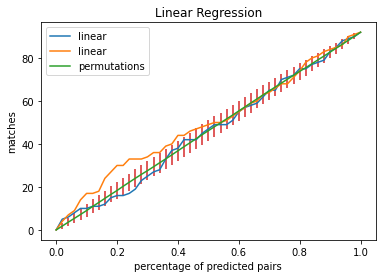

In [32]:
ax = sns.lineplot(data = linear_count160, x='percentages', y = 'matches',label='linear')
sns.lineplot(data = linearM_count160, x='percentages', y = 'matches',label='linear')
ax = sns.lineplot(data = linear_permut160, x ='percentages', y = 'mean', label='permutations')
ax.errorbar(linear_permut160['percentages'], linear_permut160['mean'], yerr=linear_permut160['std'], fmt=' ', zorder=-1)
ax.legend()
ax.set_title('Linear Regression')
ax.set_xlabel('percentage of predicted pairs')

Text(0.5, 0, 'percentage of predicted pairs')

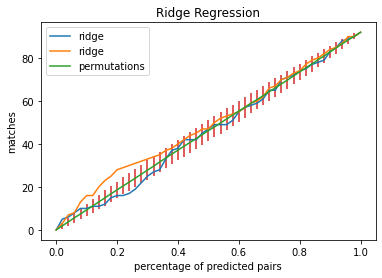

In [26]:
ax = sns.lineplot(data = ridge_count160, x='percentages', y = 'matches',label='ridge')
sns.lineplot(data = ridge151_count160, x='percentages', y = 'matches',label='ridge')
ax = sns.lineplot(data = ridge_permut160, x ='percentages', y = 'mean', label='permutations')
ax.errorbar(ridge_permut160['percentages'], ridge_permut160['mean'], yerr=ridge_permut160['std'], fmt=' ', zorder=-1)
ax.legend()
ax.set_title('Ridge Regression')
ax.set_xlabel('percentage of predicted pairs')

Text(0.5, 0, 'percentage of predicted pairs')

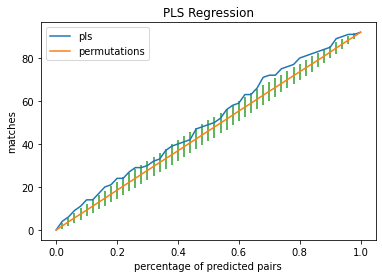

In [56]:
ax = sns.lineplot(data = pls_count160, x='percentages', y = 'matches',label='pls')
ax = sns.lineplot(data = pls_permut160, x ='percentages', y = 'mean', label='permutations')
ax.errorbar(pls_permut160['percentages'], pls_permut160['mean'], yerr=pls_permut160['std'], fmt=' ', zorder=-1)
ax.legend()
ax.set_title('PLS Regression')
ax.set_xlabel('percentage of predicted pairs')

Text(0.5, 0, 'percentage of predicted pairs')

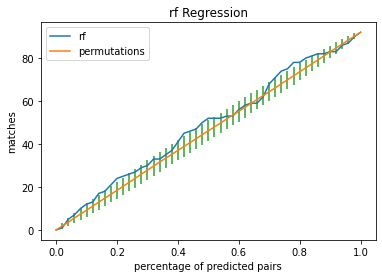

In [27]:
ax = sns.lineplot(data = rf_count160, x='percentages', y = 'matches',label='rf')
ax = sns.lineplot(data = rf_permut160, x ='percentages', y = 'mean', label='permutations')
ax.errorbar(rf_permut160['percentages'], rf_permut160['mean'], yerr=rf_permut160['std'], fmt=' ', zorder=-1)
ax.legend()
ax.set_title('rf Regression')
ax.set_xlabel('percentage of predicted pairs')

#### There are 416 matches from the RegNet database for the 160 relevant genes, looking at predictors and targets. Of those, 91 are also represented in our set of 1109*152=167,459 pairs. 

## Find largest probability for significant pairs

In [ ]:
sorted(list(zip(pca_p_values, percentages))[1:])

So, the smallest p-values, without choosing all pairs are at about 0.18 or 0.16. --> will start with 0.18

# Clusters

Clusters: took 4:45h

In [71]:
# import results from linear model
linear_permut160_00 = pd.read_pickle('linearCluster/cluster_0/permutations.pkl')

linear_count160_00 = pd.DataFrame(pd.read_pickle('linearCluster/cluster_0/count.pkl'), columns = ['matches'])
linear_permut160_00['percentages'], linear_count160_00['percentages']=percentages, percentages

linear_p_values_00, linear_z_scores_00 = get_pvalue(count = linear_count160_00, permut = linear_permut160_00)

Text(0.5, 0, 'percentage of predicted pairs')

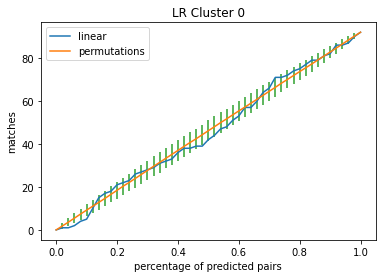

In [72]:
ax = sns.lineplot(data = linear_count160_00, x='percentages', y = 'matches',label='linear')
ax = sns.lineplot(data = linear_permut160_00, x ='percentages', y = 'mean', label='permutations')
ax.errorbar(linear_permut160_00['percentages'], linear_permut160_00['mean'], yerr=linear_permut160_00['std'], fmt=' ', zorder=-1)
ax.legend()
ax.set_title('LR Cluster 0')
ax.set_xlabel('percentage of predicted pairs')

In [73]:
# import results from linear model
linear_permut160_01 = pd.read_pickle('linearCluster/cluster_1/permutations.pkl')

linear_count160_01 = pd.DataFrame(pd.read_pickle('linearCluster/cluster_1/count.pkl'), columns = ['matches'])
linear_permut160_01['percentages'], linear_count160_01['percentages']=percentages, percentages

linear_p_values_01, linear_z_scores_01 = get_pvalue(count = linear_count160_01, permut = linear_permut160_01)

Text(0.5, 0, 'percentage of predicted pairs')

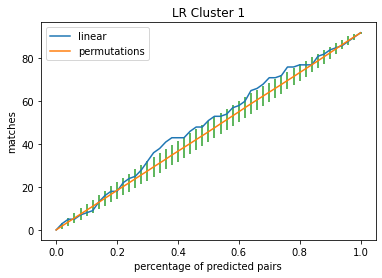

In [74]:
ax = sns.lineplot(data = linear_count160_01, x='percentages', y = 'matches',label='linear')
ax = sns.lineplot(data = linear_permut160_01, x ='percentages', y = 'mean', label='permutations')
ax.errorbar(linear_permut160_01['percentages'], linear_permut160_01['mean'], yerr=linear_permut160_01['std'], fmt=' ', zorder=-1)
ax.legend()
ax.set_title('LR Cluster 1')
ax.set_xlabel('percentage of predicted pairs')

In [75]:
# import results from linear model
linear_permut160_02 = pd.read_pickle('linearCluster/cluster_2/permutations.pkl')

linear_count160_02 = pd.DataFrame(pd.read_pickle('linearCluster/cluster_2/count.pkl'), columns = ['matches'])
linear_permut160_02['percentages'], linear_count160_02['percentages']=percentages, percentages

linear_p_values_02, linear_z_scores_02 = get_pvalue(count = linear_count160_02, permut = linear_permut160_02)

Text(0.5, 0, 'percentage of predicted pairs')

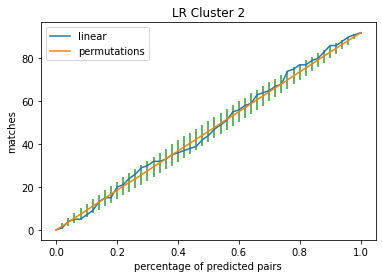

In [76]:
ax = sns.lineplot(data = linear_count160_02, x='percentages', y = 'matches',label='linear')
ax = sns.lineplot(data = linear_permut160_02, x ='percentages', y = 'mean', label='permutations')
ax.errorbar(linear_permut160_02['percentages'], linear_permut160_02['mean'], yerr=linear_permut160_02['std'], fmt=' ', zorder=-1)
ax.legend()
ax.set_title('LR Cluster 2')
ax.set_xlabel('percentage of predicted pairs')

In [77]:
# import results from linear model
linear_permut160_03 = pd.read_pickle('linearCluster/cluster_3/permutations.pkl')

linear_count160_03 = pd.DataFrame(pd.read_pickle('linearCluster/cluster_3/count.pkl'), columns = ['matches'])
linear_permut160_03['percentages'], linear_count160_03['percentages']=percentages, percentages

linear_p_values_03, linear_z_scores_03 = get_pvalue(count = linear_count160_03, permut = linear_permut160_03)

Text(0.5, 0, 'percentage of predicted pairs')

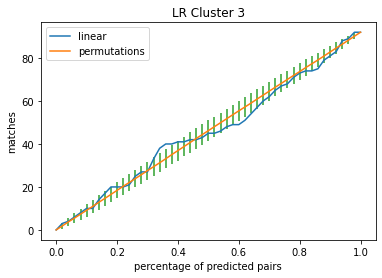

In [78]:
ax = sns.lineplot(data = linear_count160_03, x='percentages', y = 'matches',label='linear')
ax = sns.lineplot(data = linear_permut160_03, x ='percentages', y = 'mean', label='permutations')
ax.errorbar(linear_permut160_03['percentages'], linear_permut160_03['mean'], yerr=linear_permut160_03['std'], fmt=' ', zorder=-1)
ax.legend()
ax.set_title('LR Cluster 3')
ax.set_xlabel('percentage of predicted pairs')

In [79]:
# import results from linear model
linear_permut160_04 = pd.read_pickle('linearCluster/cluster_4/permutations.pkl')

linear_count160_04 = pd.DataFrame(pd.read_pickle('linearCluster/cluster_4/count.pkl'), columns = ['matches'])
linear_permut160_04['percentages'], linear_count160_04['percentages']=percentages, percentages

linear_p_values_04, linear_z_scores_04 = get_pvalue(count = linear_count160_04, permut = linear_permut160_04)

Text(0.5, 0, 'percentage of predicted pairs')

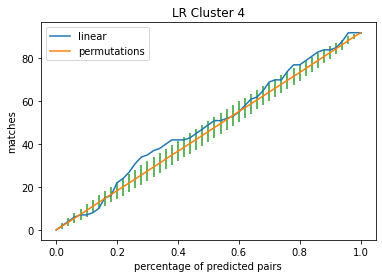

In [80]:
ax = sns.lineplot(data = linear_count160_04, x='percentages', y = 'matches',label='linear')
ax = sns.lineplot(data = linear_permut160_04, x ='percentages', y = 'mean', label='permutations')
ax.errorbar(linear_permut160_04['percentages'], linear_permut160_04['mean'], yerr=linear_permut160_04['std'], fmt=' ', zorder=-1)
ax.legend()
ax.set_title('LR Cluster 4')
ax.set_xlabel('percentage of predicted pairs')

In [81]:
# import results from linear model
linear_permut160_05 = pd.read_pickle('linearCluster/cluster_5/permutations.pkl')

linear_count160_05 = pd.DataFrame(pd.read_pickle('linearCluster/cluster_5/count.pkl'), columns = ['matches'])
linear_permut160_05['percentages'], linear_count160_05['percentages']=percentages, percentages

linear_p_values_05, linear_z_scores_05 = get_pvalue(count = linear_count160_05, permut = linear_permut160_05)

Text(0.5, 0, 'percentage of predicted pairs')

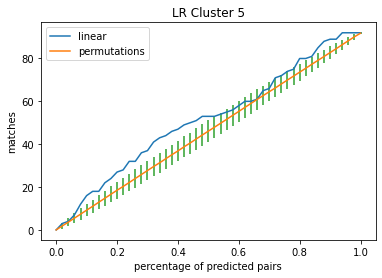

In [82]:
ax = sns.lineplot(data = linear_count160_05, x='percentages', y = 'matches',label='linear')
ax = sns.lineplot(data = linear_permut160_05, x ='percentages', y = 'mean', label='permutations')
ax.errorbar(linear_permut160_05['percentages'], linear_permut160_05['mean'], yerr=linear_permut160_05['std'], fmt=' ', zorder=-1)
ax.legend()
ax.set_title('LR Cluster 5')
ax.set_xlabel('percentage of predicted pairs')

Text(0, 0.5, 'p-values')

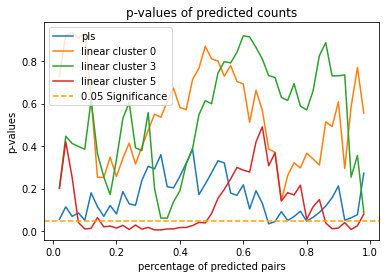

In [85]:
ax = sns.lineplot(x = percentages[1:-1], y = pls_p_values, label = 'pls')
sns.lineplot(x = percentages[1:-1], y = linear_p_values_00, label = 'linear cluster 0')
#sns.lineplot(x = percentages[1:-1], y = linear_p_values_01, label = 'linear cluster 1')
#sns.lineplot(x = percentages[1:-1], y = linear_p_values_02, label = 'linear cluster 2')
sns.lineplot(x = percentages[1:-1], y = linear_p_values_03, label = 'linear cluster 3')
#sns.lineplot(x = percentages[1:-1], y = linear_p_values_04, label = 'linear cluster 4')
sns.lineplot(x = percentages[1:-1], y = linear_p_values_05, label = 'linear cluster 5')
ax.axhline(0.05, ls = '--', c='orange', label = '0.05 Significance')
ax.legend()
ax.set_title('p-values of predicted counts')
ax.set_xlabel('percentage of predicted pairs')
ax.set_ylabel('p-values')

# PLS on Clusters

In [31]:
# import results from pls model
pls_permut160_00 = pd.read_pickle('plsCluster/cluster_0/permutations.pkl')

pls_count160_00 = pd.DataFrame(pd.read_pickle('plsCluster/cluster_0/count.pkl'), columns = ['matches'])
pls_permut160_00['percentages'], pls_count160_00['percentages']=percentages, percentages

pls_p_values_00, pls_z_scores_00 = get_pvalue(count = pls_count160_00, permut = pls_permut160_00)

Text(0.5, 0, 'percentage of predicted pairs')

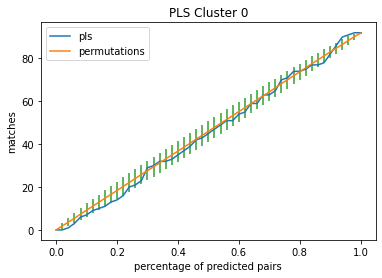

In [66]:
ax = sns.lineplot(data = pls_count160_00, x='percentages', y = 'matches',label='pls')
ax = sns.lineplot(data = pls_permut160_00, x ='percentages', y = 'mean', label='permutations')
ax.errorbar(pls_permut160_00['percentages'], pls_permut160_00['mean'], yerr=pls_permut160_00['std'], fmt=' ', zorder=-1)
ax.legend()
ax.set_title('PLS Cluster 0')
ax.set_xlabel('percentage of predicted pairs')

In [112]:
# import results from pls model
pls_permut160_01 = pd.read_pickle('plsCluster/cluster_1/permutations.pkl')

pls_count160_01 = pd.DataFrame(pd.read_pickle('plsCluster/cluster_1/count.pkl'), columns = ['matches'])
pls_permut160_01['percentages'], pls_count160_01['percentages']=percentages, percentages

pls_p_values_01, pls_z_scores_01 = get_pvalue(count = pls_count160_01, permut = pls_permut160_01)

Text(0.5, 0, 'percentage of predicted pairs')

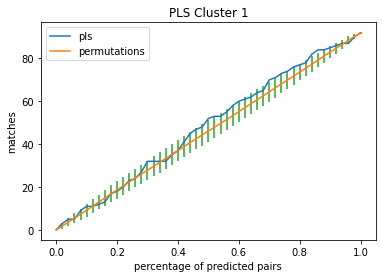

In [111]:
ax = sns.lineplot(data = pls_count160_01, x='percentages', y = 'matches',label='pls')
ax = sns.lineplot(data = pls_permut160_01, x ='percentages', y = 'mean', label='permutations')
ax.errorbar(pls_permut160_01['percentages'], pls_permut160_01['mean'], yerr=pls_permut160_01['std'], fmt=' ', zorder=-1)
ax.legend()
ax.set_title('PLS Cluster 1')
ax.set_xlabel('percentage of predicted pairs')

In [105]:
# import results from pls model
pls_permut160_05 = pd.read_pickle('plsC05/cluster_5/permutations.pkl')

pls_count160_05 = pd.DataFrame(pd.read_pickle('plsC05/cluster_5/count.pkl'), columns = ['matches'])
pls_permut160_05['percentages'], pls_count160_05['percentages']=percentages, percentages

pls_p_values_05, pls_z_scores_05 = get_pvalue(count = pls_count160_05, permut = pls_permut160_05)

Text(0.5, 0, 'percentage of predicted pairs')

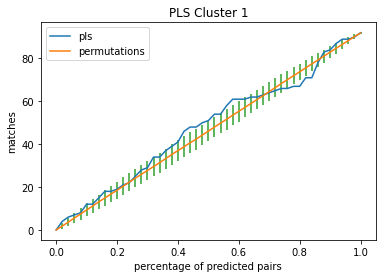

In [106]:
ax = sns.lineplot(data = pls_count160_05, x='percentages', y = 'matches',label='pls')
ax = sns.lineplot(data = pls_permut160_05, x ='percentages', y = 'mean', label='permutations')
ax.errorbar(pls_permut160_05['percentages'], pls_permut160_05['mean'], yerr=pls_permut160_05['std'], fmt=' ', zorder=-1)
ax.legend()
ax.set_title('PLS Cluster 5')
ax.set_xlabel('percentage of predicted pairs')

Text(0, 0.5, 'p-values')

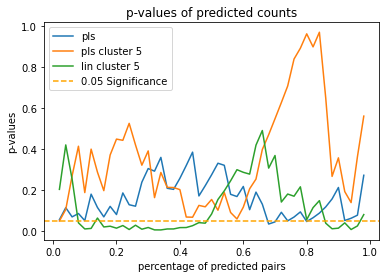

In [110]:
ax = sns.lineplot(x = percentages[1:-1], y = pls_p_values, label = 'pls')
#sns.lineplot(x = percentages[1:-1], y = pls_p_values_00, label = 'pls cluster 0')
#sns.lineplot(x = percentages[1:-1], y = linear_p_values_00, label = 'lin cluster 0')
#sns.lineplot(x = percentages[1:-1], y = pls_p_values_01, label = 'pls cluster 1')
#sns.lineplot(x = percentages[1:-1], y = linear_p_values_01, label = 'lin cluster 1')
#sns.lineplot(x = percentages[1:-1], y = pls_p_values_02, label = 'pls cluster 2')
#sns.lineplot(x = percentages[1:-1], y = pls_p_values_03, label = 'pls cluster 3')
#sns.lineplot(x = percentages[1:-1], y = pls_p_values_04, label = 'pls cluster 4')
sns.lineplot(x = percentages[1:-1], y = pls_p_values_05, label = 'pls cluster 5')
sns.lineplot(x = percentages[1:-1], y = linear_p_values_05, label = 'lin cluster 5')
ax.axhline(0.05, ls = '--', c='orange', label = '0.05 Significance')
ax.legend()
ax.set_title('p-values of predicted counts')
ax.set_xlabel('percentage of predicted pairs')
ax.set_ylabel('p-values')

# CV Scores

In [98]:
pca_scores160 = pd.read_pickle('pca/Scores.pkl')
pls_scores160 = pd.read_pickle('pls/Scores.pkl')
rf_scores160 = pd.read_pickle('rf/Scores.pkl')
linear_scores160 = pd.read_pickle('linearQuick/Scores.pkl')
ridge_scores160 = pd.read_pickle('ridge/Scores.pkl')

In [128]:
pls0 = pd.read_pickle('plsCluster/cluster_0/Scores.pkl')
pls1 = pd.read_pickle('plsCluster/cluster_1/Scores.pkl')
pls2 = pd.read_pickle('plsCluster/cluster_2/Scores.pkl')
pls5 = pd.read_pickle('plsC05/cluster_5/Scores.pkl')

In [130]:
lin0 = pd.read_pickle('linearCluster/cluster_0/Scores.pkl')
lin1 = pd.read_pickle('linearCluster/cluster_1/Scores.pkl')
lin2 = pd.read_pickle('linearCluster/cluster_2/Scores.pkl')


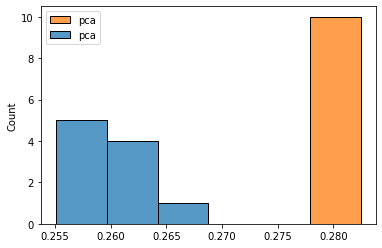

In [89]:
ax = sns.histplot(linear_scores160[['test_r2', 'train_r2']], label='linear')
#sns.histplot(linear_scores160[['test_r2', 'train_r2']], label='linear')
#sns.histplot(pls_scores160[['test_r2', 'train_r2']], label='pls')
ax.legend()

In [134]:
lin2

,estimator,test_r2,train_r2,test_neg_mean_squared_error,train_neg_mean_squared_error
0,LinearRegression(),-4.729187e+12,0.534911,-0.671478,-0.580203
1,LinearRegression(),-3.368667e+11,0.533187,-0.692648,-0.579058
2,LinearRegression(),-1.030149e+13,0.535076,-0.754686,-0.577852
3,LinearRegression(),-4.967558e+12,0.534675,-0.667315,-0.581071
4,LinearRegression(),-4.537923e+12,0.536775,-0.704851,-0.577290
5,LinearRegression(),-4.515784e+12,0.536832,-0.670944,-0.580285
6,LinearRegression(),-7.855570e+12,0.536734,-0.713262,-0.578378
7,LinearRegression(),-6.101833e+12,0.537836,-0.713408,-0.576125
8,LinearRegression(),-3.610794e+12,0.538152,-0.709100,-0.577152
9,LinearRegression(),3.775234e-01,0.538439,-0.685028,-0.579364


In [133]:
np.mean(lin2['test_r2'])

-4695700489543.543

In [132]:
np.mean(lin1['train_r2'])

0.4095654213833675